# EDA - atmaCup16 with Recruit

https://www.guruguru.science/competitions/22/data-sources

In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## train/test_log.csv

学習 / テスト用の期間に対するあるセッションごとに出現した宿を記録したログデータです。seq_no が見た順番を表します。

- session_id: セッションごとに割り振られたユニークな ID.
- seq_no: セッション内で出現した順番
- yad_no: 出現した宿 No

補足
- 連続した同じ宿が出現する場合それらは一つの宿 ID にまとめていることに注意してください。
- セッション内で最後に出現する宿は必ず正解ラベルとは異なる宿となります。これは現在閲覧している宿とは違う宿をレコメンドしたいというニーズのためです。

In [2]:
train_logs_df = pd.read_csv("/kaggle/input/atmacup16-recruit/train_log.csv")
test_logs_df = pd.read_csv("/kaggle/input/atmacup16-recruit/test_log.csv")

In [3]:
train_logs_df

,session_id,seq_no,yad_no
0,000007603d533d30453cc45d0f3d119f,0,2395
1,0000ca043ed437a1472c9d1d154eb49b,0,13535
2,0000d4835cf113316fe447e2f80ba1c8,0,123
3,0000fcda1ae1b2f431e55a7075d1f500,0,8475
4,000104bdffaaad1a1e0a9ebacf585f33,0,96
...,...,...,...
419265,ffffcd5bc19d62cad5a3815c87818d83,0,12230
419266,ffffcd5bc19d62cad5a3815c87818d83,1,10619
419267,ffffcd5bc19d62cad5a3815c87818d83,2,12230
419268,fffffa7baf370083ebcdd98f26a7e31a,0,2439


In [4]:
test_logs_df

,session_id,seq_no,yad_no
0,00001149e9c73985425197104712478c,0,3560
1,00001149e9c73985425197104712478c,1,1959
2,0000e02747d749a52b7736dfa751e258,0,11984
3,0000f17ae2628237d78d3a38b009d3be,0,757
4,0000f17ae2628237d78d3a38b009d3be,1,8922
...,...,...,...
250300,fffee3199ef94b92283239cd5e3534fa,1,8336
250301,ffff62c6bb49bc9c0fbcf08494a4869c,0,12062
250302,ffff9a7dcc892875c7a8b821fa436228,0,8989
250303,ffffb1d30300fe17f661941fd085b04b,0,6030


### session_id

In [5]:
# session_id数
train_logs_df["session_id"].nunique()

288698

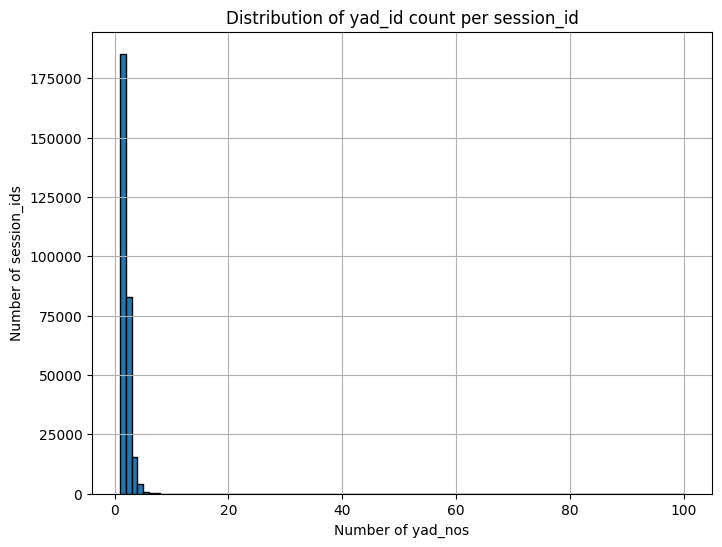

セッションあたりの閲覧数の平均値: 1.4522788519490957
セッションあたりの閲覧数の中央値: 1.0
セッションあたりの閲覧数の最大値: 10


In [6]:
# session_idごとのyado_idの数を計算
num_yads_per_session_id = train_logs_df.groupby("session_id").size()

# ヒストグラムの描画
plt.figure(figsize=(8, 6))
num_yads_per_session_id.hist(bins=range(1, 101), edgecolor="black")

plt.title("Distribution of yad_id count per session_id")
plt.xlabel("Number of yad_nos")
plt.ylabel("Number of session_ids")

plt.show()

# 統計量の計算
avg_num_yads = num_yads_per_session_id.mean()
med_num_yads = num_yads_per_session_id.median()
max_num_yads = num_yads_per_session_id.max()

print(f"セッションあたりの閲覧数の平均値: {avg_num_yads}")
print(f"セッションあたりの閲覧数の中央値: {med_num_yads}")
print(f"セッションあたりの閲覧数の最大値: {max_num_yads}")

所感
- セッションベースのためとても少ない
- 前処理での除外の影響もありそう

In [7]:
total_sessions = train_logs_df["session_id"].nunique()
total_yads = train_logs_df["yad_no"].nunique()
total_comb = total_sessions * total_yads

# 実際の行動ログ内にあるセッションと宿の組み合わせの数
actual_comb = train_logs_df.drop_duplicates(
    subset=["session_id", "yad_no"]
).shape[0]

density = actual_comb / total_comb * 100

print(f"全セッション数: {total_sessions}")
print(f"（行動ログ内の）全宿数: {total_yads}")
print(f"density: {density:.3f}%")

全セッション数: 288698
（行動ログ内の）全宿数: 13372
density: 0.010%


- densityが低いので、閲覧されている宿に偏りがある？

### 人気アイテム

yad_no
3338     1422
12350    1115
10095     946
13468     879
8567      843
         ... 
10115       1
9487        1
1871        1
7278        1
9594        1
Name: count, Length: 13372, dtype: int64


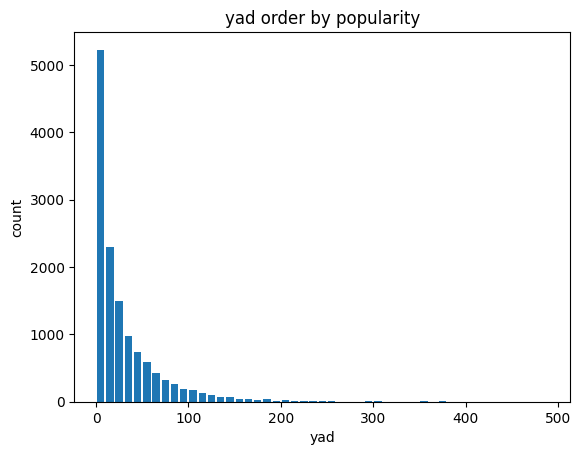

In [8]:
yad_counts = train_logs_df["yad_no"].value_counts()

print(yad_counts)

plt.hist(yad_counts, rwidth=0.8, bins=range(0, 500, 10))
plt.title("yad order by popularity")
plt.xlabel("yad")
plt.ylabel("count")

plt.show()

In [9]:
top_100_yad_counts = yad_counts[:100].sum()

top_100_ratio = top_100_yad_counts/yad_counts.sum()
print(f"全閲覧イベントにおけるTop100アイテムの割合: {top_100_ratio}, 全アイテム数: {len(yad_counts.keys())}")

全閲覧イベントにおけるTop100アイテムの割合: 0.09180003339137072, 全アイテム数: 13372


## train_label.csv

学習データのセッションが最終的にどの宿を予約したかを記録したcsvファイルです。

- session_id: セッションごとに割り振られたユニークな ID
- yad_no: 予約した宿 ID

In [10]:
train_labels_df = pd.read_csv("/kaggle/input/atmacup16-recruit/train_label.csv")

In [11]:
train_labels_df

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,4101
1,0000ca043ed437a1472c9d1d154eb49b,8253
2,0000d4835cf113316fe447e2f80ba1c8,4863
3,0000fcda1ae1b2f431e55a7075d1f500,1652
4,000104bdffaaad1a1e0a9ebacf585f33,96
...,...,...
288693,ffff2262d38abdeb247ebd591835dcc9,2259
288694,ffff2360540745117193ecadcdc06538,963
288695,ffff7fb4617164b2604aaf51c40bf82d,13719
288696,ffffcd5bc19d62cad5a3815c87818d83,10619


## yado.csv

宿に関する属性情報が記録された csv ファイルです。

- yad_no: 宿ごとに割り振られたユニークな ID

以下は宿の属性に関する情報です。

- yad_type : 宿泊種別 lodging type
- total_room_cnt : 部屋数 total number of rooms
- wireless_lan_flg : 無線 LAN があるかどうか wireless LAN connection
- onsen_flg : 温泉を有しているかどうか flag with hot spring
- kd_stn_5min : 駅まで 5 分以内かどうか within 5 minutes walk from the station
- kd_bch_5min : ビーチまで 5 分以内かどうか within 5 minutes walk to the beach
- kd_slp_5min : ゲレンデまで 5 分以内かどうか within 5 minutes walk to the slopes
- kd_conv_walk_5min : コンビニまで 5 分以内かどうか within 5 minutes walk to convenience store

以下は宿の場所に関する情報です。「広域」から「小エリア」は階層構造になっています。(ex: 広域エリアには複数の県が紐づくが、一つの県に対しては一つの広域エリアのみが紐づく)

- wid_cd : 広域エリア CD wide area CD
- ken_cd : 県 CD prefecture CD
- lrg_cd : 大エリア CD large area CD
- sml_cd : 小エリア CD small area CD

所感

- total_room_cnt: この特徴量で宿の規模感がわかる
- flg系
    - wireless_lan_flg(無線LAN), onsen_flg(温泉)は見るかも
    - kd_stn_5min(駅近), kd_conv_walk_5min(コンビニ近い)
    - kd_bch_5min(ビーチ近い), kd_slp_5min(ゲレンデ近い)
- ビーチとゲレンデに関しては、学習データにtime_stampがあれば有効だったかもしれない
    - むしろ、kd_bch_5min, kd_slp_5minをデータ観察すれば、季節がわかるかも
    - kd_bch_5minが多い時期は夏だし、kd_slp_5minが多い時期は冬
- 意外と説明変数少ないかも
    - 2週間のコンペというのもありそう
    - 宿の料金データ欲しい

宿の調べ方

- 旅行先の大エリア・小エリアから絞る
    - lrg_cd, sml_cdくらい？

In [12]:
yados_df = pd.read_csv("/kaggle/input/atmacup16-recruit/yado.csv")
yados_df = yados_df.fillna(
    {
        "wireless_lan_flg": 0,
        "onsen_flg": 0,
        "kd_stn_5min": 0,
        "kd_bch_5min": 0,
        "kd_slp_5min": 0,
        "kd_conv_walk_5min": 0,
    }
).astype(
    {
        "yad_no": np.int32,
        "yad_type": np.int8,
#         "total_room_count": np.int32, # TODO: NaNの扱い（中央値とする？）
        "wireless_lan_flg": np.int8,
        "onsen_flg": np.int8,
        "kd_stn_5min": np.int8,
        "kd_slp_5min": np.int8,
        "kd_bch_5min": np.int8,
        "kd_conv_walk_5min": np.int8,        
    }
)

In [13]:
yados_df

,yad_no,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd
0,1,0,129.0,1,0,1,0,0,1,f0112abf369fb03cdc5f5309300913da,072c85e1653e10c9c7dd065ad007125a,449c52ef581d5f9ef311189469a0520e,677a32689cd1ad74e867f1fbe43a3e1c
1,2,0,23.0,1,0,0,0,0,0,d86102dd9c232bade9a97dccad40df48,b4d2fb4e51ea7bca80eb1270aa474a54,5c9a8f48e9df0234da012747a02d4b29,4ee16ee838dd2703cc9a1d5a535f0ced
2,3,0,167.0,1,1,1,0,0,1,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,ab9480fd72a44d51690ab16c4ad4d49c
3,4,0,144.0,1,0,1,0,0,1,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52c9ea83f2cfe92be54cb6bc961edf21,1cc3e1838bb0fd0fde0396130b1f82b9
4,5,0,41.0,1,1,0,0,0,0,43875109d1dab93592812c50d18270a7,75617bb07a2785a948ab1958909211f1,9ea5a911019b66ccd42f556c42a2fe2f,be1b876af18afc4deeb3081591d2a910
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13801,13802,0,10.0,1,1,0,0,0,0,c312e07b7a5d456d53a5b00910a336e1,558ac1909f0318b82c621ab250329d6d,80fb3c5ad0c89931d0923e9f80885218,5eb30820716082c720836733d73c605e
13802,13803,0,NaN,0,0,1,0,0,1,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,e5cfcc0a43c82072aca11628ff0add53,20ad8785a30f125bee5a8a325782ab06
13803,13804,0,80.0,1,1,0,1,0,1,d86102dd9c232bade9a97dccad40df48,7d76599bd27ff9e7823b2b1323ca763e,c5fe8848b6ab39b040cdb3668aea9433,b3eab50ccf6ffb51c37d36ee384abfbf
13804,13805,0,8.0,1,1,0,0,0,1,3300cf6f774b7c6a5807110f244cbc21,689cf8289e7ea0b2eef1b017dcdfe8de,8b712435430a6875839a6c3b5a40b008,2b4165444a777465576b25f65697d739


- 13806件と少ないかも

In [14]:
yados_df.describe()

,yad_no,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min
count,13806.000000,13806.000000,12973.000000,13806.000000,13806.000000,13806.000000,13806.000000,13806.000000,13806.000000
mean,6903.500000,0.012024,87.854929,0.797262,0.357164,0.385412,0.057077,0.018760,0.605099
std,3985.593243,0.108996,107.382317,0.402053,0.479181,0.486710,0.231997,0.135681,0.488847
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3452.250000,0.000000,21.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6903.500000,0.000000,52.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,10354.750000,0.000000,120.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,13806.000000,1.000000,2384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### yad_type

yad_type
0    13640
1      166
Name: yad_no, dtype: int64


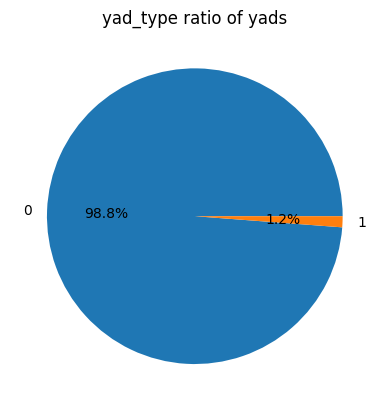

In [15]:
yad_type_df = yados_df.groupby("yad_type")["yad_no"].count()

print(yad_type_df)

plt.pie(yad_type_df, labels=yad_type_df.index, autopct="%1.1f%%")
plt.title("yad_type ratio of yads")
plt.show()

### total_room_cnt

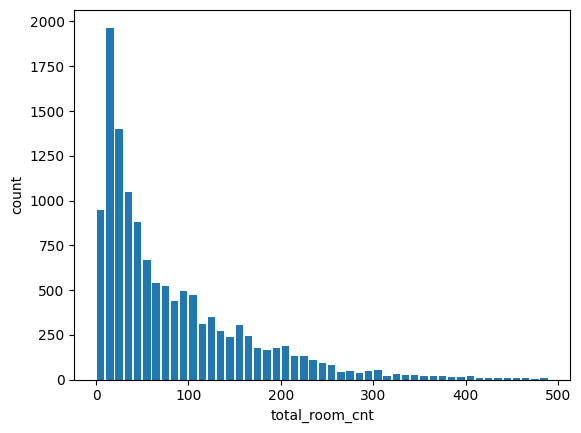

In [16]:
plt.hist(yados_df["total_room_cnt"], rwidth=0.8, bins=range(0, 500, 10))
plt.xlabel("total_room_cnt")
plt.ylabel("count")

plt.show()

### flg

- wireless_lan_flg : 無線 LAN があるかどうか wireless LAN connection
- onsen_flg : 温泉を有しているかどうか flag with hot spring
- kd_stn_5min : 駅まで 5 分以内かどうか within 5 minutes walk from the station
- kd_bch_5min : ビーチまで 5 分以内かどうか within 5 minutes walk to the beach
- kd_slp_5min : ゲレンデまで 5 分以内かどうか within 5 minutes walk to the slopes
- kd_conv_walk_5min : コンビニまで 5 分以内かどうか within 5 minutes walk to convenience store

wireless_lan_flg
0     2799
1    11007
Name: yad_no, dtype: int64


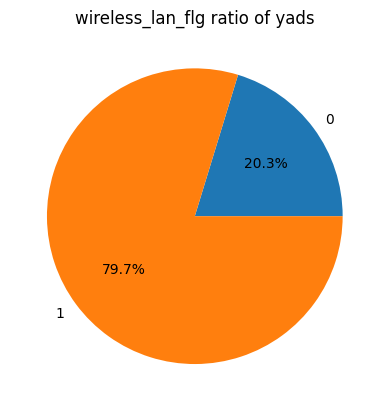

onsen_flg
0    8875
1    4931
Name: yad_no, dtype: int64


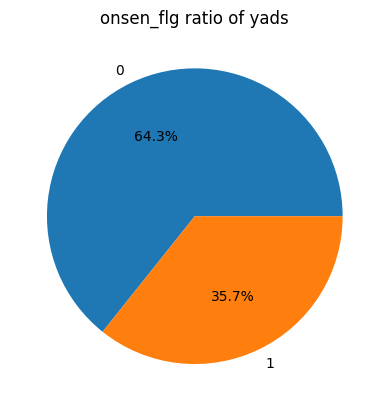

kd_stn_5min
0    8485
1    5321
Name: yad_no, dtype: int64


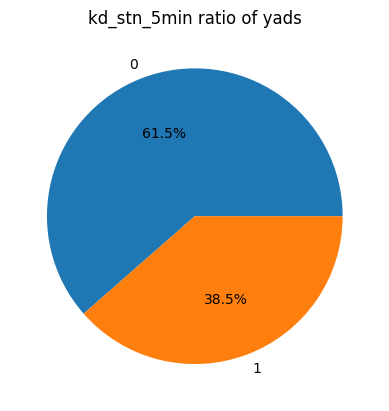

kd_bch_5min
0    13018
1      788
Name: yad_no, dtype: int64


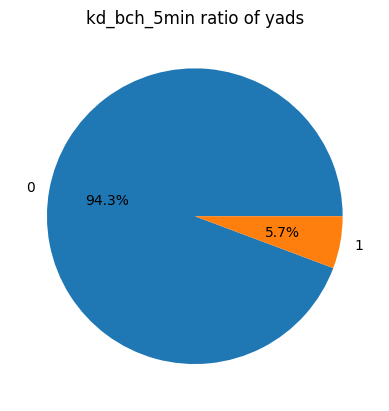

kd_slp_5min
0    13547
1      259
Name: yad_no, dtype: int64


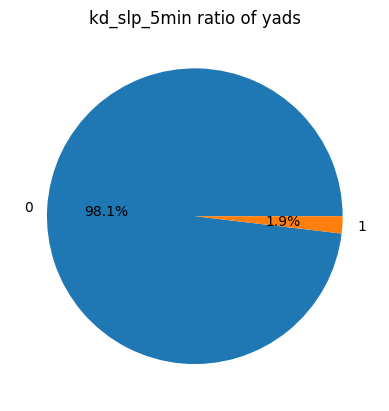

kd_conv_walk_5min
0    5452
1    8354
Name: yad_no, dtype: int64


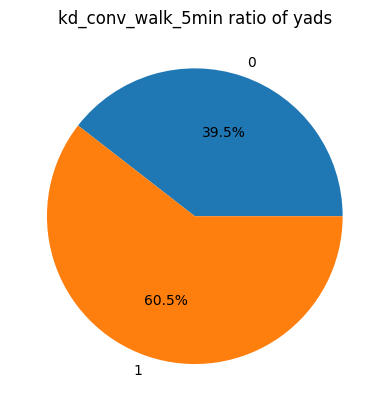

In [17]:
flgs = [
    "wireless_lan_flg",
    "onsen_flg",
    "kd_stn_5min",
    "kd_bch_5min",
    "kd_slp_5min",
    "kd_conv_walk_5min",
]

for v in flgs:
    df = yados_df.groupby(v)["yad_no"].count()

    print(df)

    plt.pie(df, labels=df.index, autopct="%1.1f%%")
    plt.title(f"{v} ratio of yads")
    plt.show()

### cd

- wid_cd : 広域エリア CD wide area CD
- ken_cd : 県 CD prefecture CD
- lrg_cd : 大エリア CD large area CD
- sml_cd : 小エリア CD small area CD

- TODO: 宿の部屋数は近いものを予約しそう

## image_embeddings.parquet

宿ごとに設定された画像の埋め込み結果です。

- yad_no: 宿No
- category: 画像の種類
- emb_0 ~ emb_511: 対応する画像埋め込み結果